Homework 4
==========

There are two parts of this homework. In the first part, you need to implement the backward pass of the **fully-connected layer** and the **convolutional layer**. In the second part, we play around with **finetuning** and **adversarial attacks** on the neural networks!

- **Task 1: Implement NN Layers (60 points)**
    - Implement the `backward_pass` of fully connected layer (30 points).
    - Implement the `backward_pass` of convolutional layer (30 points).
- **Task 2: Fintuning and Adversarial Attacks (40 points)**
    - Implement the `train` function to complete fintuinig (20 points, 5 points per correct label in testing).
    - Adversarial attacks on 4 images of 4 classes (5 points each).

- Your job is to implement the sections marked with TODO to complete the tasks.

- Submission 
    - Please submit the notebook (ipynb and pdf) including the output of all cells.

- Note: Please install PyTorch on your machine by running the following command in the terminal:
    - `pip install -U torch torchvision`
    - More guideline can be found on [PyTorch Official Website](https://pytorch.org/get-started/locally/)
    - Task 2 is not computational intensive so you can run it on your local machine's CPU.
    - If you want to use GPU, try [Google CoLab](https://colab.research.google.com/) and there are usually free GPUs available. 
    - There are some [tutorials](https://towardsdatascience.com/getting-started-with-google-colab-f2fff97f594c) available on how to use Colab's GPU and have your own storage.

Task 1 - Implemenet NN Layers
-----

### 1.1 Fully Connected Layer
Before we get started, let's recall what happens in the forward pass of a full-connected layer.

In [1]:
import math
import numpy as np

class Linear():
    """A fully-connected NN layer.
    Parameters:
    -----------
    n_units: int
        The number of neurons in the layer.
    input_shape: tuple
        The expected input shape of the layer. For dense layers a single digit specifying
        the number of features of the input. Must be specified if it is the first layer in
        the network.
    """
    def __init__(self, n_units, input_shape=None):
        # For simplisity, we omit optimizer in our homework.
        # Therefore, you do not need to worry about parameter update.
        self.layer_input = None
        self.input_shape = input_shape
        self.n_units = n_units
        self.trainable = True
        self.W = None 
        self.b = None
        self.initialize()

    def initialize(self):
        # Initialize the weights
        limit = 1 / math.sqrt(self.input_shape[0])
        self.W  = np.random.uniform(-limit, limit, (self.input_shape[1], self.n_units))
        self.b = np.zeros((1, self.n_units))

    def forward_pass(self, inp):
        self.layer_input = inp
        return np.dot(inp, self.W) + self.b

Below we provided some helper functions that might be useful:

In [2]:
def SE(out, target):
    '''
    return square error.
    '''
    return 0.5 * (target - out)**2

def get_target(inp, W, b):
    '''
    W and b are assumed ideal weights and bias.
    '''
    return np.dot(inp, W) + b

def grad_check(layer, inp, W, b):
    '''
    calculate gradient from numerical method, we compare the analytical gradient and numerical gradient.
    
    We say your calculated gradients are correct when the mean square error between 
    standard gradient and your gradient is below some threshold.
    
    return true when gradients of W, b and inp are calculated correctly.
    '''
    res = True
    target = get_target(inp, W, b)
#     print(target.shape)
    out = layer.forward_pass(inp)
    y = SE(target, out)
    loss = target - out
#     print(loss.shape)
    accum_grad = layer.backward_pass(loss)
    
    W_shape = layer.W.shape
    b_shape = layer.b.shape
    inp_shape = inp.shape
    
    limit = 1e-6
    threshold = 1e-8 * inp_shape[0]**2
    
    W_diff = np.zeros(W_shape)
    for i in range(W_shape[0]):
        noise = np.random.rand(W_shape[1]) * limit
        layer.W[i,:] += noise
        out2 = layer.forward_pass(inp)
        y2 = SE(target, out2)
#         print(y2.shape)
        W_diff[i,:] = np.sum(y - y2, axis=0) / noise
#         print(W_diff.shape)
        layer.W[i,:] -= noise
        
    res &= (np.sum((W_diff - layer.grad_W)**2) < threshold)
    
    noise = np.random.rand(*b_shape) * limit
    layer.b += noise
    out2 = layer.forward_pass(inp)
    y2 = SE(target, out2)
    b_diff = np.sum(y - y2, axis=0) / noise
    layer.b -= noise
    res &= (np.sum((b_diff - layer.grad_b)**2) < threshold)
    
    inp_diff = np.zeros(inp_shape)
    for j in range(inp_shape[1]):
        noise = np.random.rand(inp_shape[0]) * limit
        inp[:,j] += noise
        out2 = layer.forward_pass(inp)
        y2 = SE(target, out2)
        inp_diff[:,j] = np.sum(y - y2, axis=1) / noise
        inp[:,j] -= noise
    
    res &= (np.sum((inp_diff - accum_grad)**2) < threshold) 
    
    return res

### Implement the Backward Pass
Now you can start building your own backward function of the fully connected layer.

In [3]:
def backward_pass_fc(self, accum_grad):
    '''
    TODO: Implement the backward_pass_fc here.
    
    Parameter:
    ----------
        accum_grad: gradient propogated back from the next layer
        
    Return:
    ----------
        accum_grad_result: gradient propogated back from the this layer
    '''
    
    self.grad_W = np.dot(self.layer_input.T, accum_grad)
    self.grad_b = np.sum(accum_grad, axis=0)
    
    accum_grad_result = np.dot(accum_grad, self.W.T)
    return accum_grad_result

### Test your implementation
Use grad_check to test the correctness of your backward implementation:

In [4]:
Linear.backward_pass = backward_pass_fc

inp = np.random.rand(100,3)
layer = Linear(2, inp.shape)

W = np.random.rand(3,2)
b = np.random.rand(1,2)

if grad_check(layer, inp, W, b):
    print("[INFO] Testing Backward Pass: Pass!")
else:
    print("[WARN] Testing Backward Pass: Fail!")

[INFO] Testing Backward Pass: Pass!


### 1.2 Convolutional Layer
Before we get started, let's recall what happens in the forward pass of a convolutional layer.    

In [5]:
class Conv2D():
    """A 2D Convolution Layer.

    Parameters:
    -----------
    n_filters: int
        The number of filters that will convolve over the input matrix. The number of channels
        of the output shape.
    filter_shape: tuple
        A tuple (filter_height, filter_width).
    input_shape: tuple
        The shape of the expected input of the layer. (batch_size, channels, height, width)
        Only needs to be specified for first layer in the network.
    padding: string
        Either 'same' or 'valid'. 'same' results in padding being added so that the output height and width
        matches the input height and width. For 'valid' no padding is added.
        By default, we use 'same' to test the implementation.
    stride: int
        The stride length of the filters during the convolution over the input.
    """
    
    def __init__(self, n_filters, filter_shape, input_shape, padding='same', stride=1):
        self.n_filters = n_filters
        self.filter_shape = filter_shape
        self.padding = padding
        self.stride = stride
        self.input_shape = input_shape
        self.trainable = True
        self.W = None
        self.w0 = None
        self.initialize()

    def initialize(self):
        # Initialize the weights
        filter_height, filter_width = self.filter_shape
        batch, channels, height, width = self.input_shape
        limit = 1 / math.sqrt(np.prod(self.filter_shape))
        self.W  = np.random.uniform(-limit, limit, size=(self.n_filters, channels, filter_height, filter_width))
        self.w0 = np.zeros((self.n_filters, 1))

    def output_shape(self):
        batch, channels, height, width = self.input_shape
        pad_h, pad_w = determine_padding(self.filter_shape, output_shape=self.padding)
        output_height = (height + np.sum(pad_h) - self.filter_shape[0]) / self.stride + 1
        output_width = (width + np.sum(pad_w) - self.filter_shape[1]) / self.stride + 1
        return self.n_filters, int(output_height), int(output_width)
    
    def forward_pass(self, X):
        batch_size, channels, height, width = X.shape
        self.layer_input = X
        # Turn image shape into column shape
        # (enables dot product between input and weights)
        self.X_col = image_to_column(X, self.filter_shape, stride=self.stride, output_shape=self.padding)
        
        # Turn weights into column shape
        self.W_col = self.W.reshape((self.n_filters, -1))
        # Calculate output
        output = self.W_col.dot(self.X_col) + self.w0
        # Reshape into (n_filters, out_height, out_width, batch_size)
        output = output.reshape(self.output_shape() + (batch_size, ))
        # Redistribute axises so that batch size comes first
        return output.transpose(3,0,1,2)

Below we provided some helper functions that might be useful:

In [6]:
# Method which turns the image shaped input to column shape.
# Used during the forward pass.
# Reference: CS231n Stanford
def image_to_column(images, filter_shape, stride, output_shape='same'):
    filter_height, filter_width = filter_shape

    pad_h, pad_w = determine_padding(filter_shape, output_shape)

    # Add padding to the image
    images_padded = np.pad(images, ((0, 0), (0, 0), pad_h, pad_w), mode='constant')

    # Calculate the indices where the dot products are to be applied between weights
    # and the image
    k, i, j = get_im2col_indices(images.shape, filter_shape, (pad_h, pad_w), stride)

    # Get content from image at those indices
    cols = images_padded[:, k, i, j]
    channels = images.shape[1]
    # Reshape content into column shape
    
    cols = cols.transpose(1, 2, 0).reshape(filter_height * filter_width * channels, -1)
    return cols

# Reference: CS231n Stanford
def get_im2col_indices(images_shape, filter_shape, padding, stride=1):
    # First figure out what the size of the output should be
    batch_size, channels, height, width = images_shape
    filter_height, filter_width = filter_shape
    pad_h, pad_w = padding
    out_height = int((height + np.sum(pad_h) - filter_height) / stride + 1)
    out_width = int((width + np.sum(pad_w) - filter_width) / stride + 1)

    i0 = np.repeat(np.arange(filter_height), filter_width)
    i0 = np.tile(i0, channels)
    i1 = stride * np.repeat(np.arange(out_height), out_width)
    j0 = np.tile(np.arange(filter_width), filter_height * channels)
    j1 = stride * np.tile(np.arange(out_width), out_height)
    i = i0.reshape(-1, 1) + i1.reshape(1, -1)
    j = j0.reshape(-1, 1) + j1.reshape(1, -1)
    

    k = np.repeat(np.arange(channels), filter_height * filter_width).reshape(-1, 1)
    return (k, i, j)

# Method which calculates the padding based on the specified output shape and the
# shape of the filters
def determine_padding(filter_shape, output_shape="same"):
    # No padding
    if output_shape == "valid":
        return (0, 0), (0, 0)
    # Pad so that the output shape is the same as input shape (given that stride=1)
    elif output_shape == "same":
        filter_height, filter_width = filter_shape

        # Derived from:
        # output_height = (height + pad_h - filter_height) / stride + 1
        # In this case output_height = height and stride = 1. This gives the
        # expression for the padding below.
        pad_h1 = int(math.floor((filter_height - 1)/2))
        pad_h2 = int(math.ceil((filter_height - 1)/2))
        pad_w1 = int(math.floor((filter_width - 1)/2))
        pad_w2 = int(math.ceil((filter_width - 1)/2))

        return (pad_h1, pad_h2), (pad_w1, pad_w2)

### Implement Backward Pass
Now you can start building your own backward function.

In [7]:
def backward_pass_conv(layer, accum_grad):
    '''
    TODO: Implement the backward_pass_fc here.
    
    Parameter:
    ----------
        accum_grad: gradient propogated back from the next layer
        
    Return:
    ----------
        accum_grad_result: gradient propogated back from the this layer
    '''
    
    batch, channels, height, width = layer.input_shape
    
    W = layer.W.transpose(1,0,2,3).reshape(channels, layer.n_filters, -1)
    W = W[:,:,::-1]
    W = W.reshape(channels, layer.n_filters, layer.filter_shape[0], layer.filter_shape[1])

    X_col = image_to_column(accum_grad, layer.filter_shape, stride=layer.stride, output_shape=layer.padding)
        
    W_col = W.reshape((channels, -1))
    accum_grad_result = W_col.dot(X_col)
    accum_grad_result = accum_grad_result.reshape((channels, height, width, batch))
    return accum_grad_result.transpose(3,0,1,2)


### Test your implementation:
We use preloaded input, output, weight and bias tensor to test the implementation of your forward pas and backward pass. 

In [8]:
def conv_test():
    Conv2D.backward_pass = backward_pass_conv

    # np.load return the k,v pair of the name and value of numpy matrix
    data = np.load('test.npz')

    # read the input from npz file
    input_tensor = data['input_tensor']
    
    # read the forward pass result from npz file
    output_tensor = data['output_tensor']
    
    # read the target from npz file
    target_tensor = data['target_tensor']
    
    # read the backward pass result from npz file
    accum_grad = data['accum_grad']
    
    # read the preloaded weight and bias from npz file
    w0 = data['w0']
    W = data['W']

    # read the configuration from npz file
    filter_size = data['filter_size']
    filter_num = data['filter_num']

    # configure the 
    layer = Conv2D(n_filters=filter_num, filter_shape=(filter_size, filter_size), input_shape=input_tensor.shape)
    layer.W, layer.w0 = W, w0
    predict_tensor = layer.forward_pass(input_tensor)

    # Test the forward pass implementation
    if SE(predict_tensor, output_tensor).all() < 1e-1:
        print("[INFO] Testing Forward: Pass!")
    else:
        print("[WARN] Testing Forward: Fail!")

    # use the tensors read from the npz file to compute the loss
    loss = target_tensor - output_tensor
    predict_accum_grad = layer.backward_pass(loss)
   

    # Test the backward pass implementation
    if SE(predict_accum_grad, accum_grad).all() < 1e-1:
        print("[INFO] Testing Backward: Pass!")
    else:
        print("[WARN] Testing Backward: Fail!")

In [9]:
conv_test()

[INFO] Testing Forward: Pass!
[INFO] Testing Backward: Pass!


Task 2 - Finetuning and Adversarial Attacks
-----

### Setup
We are using [MobileNetV2](https://arxiv.org/abs/1801.04381) archiecture for this task, which is light-weighted so don't worry if you don't have access to GPUs.    
Also, we encourage you to try the code on [Google CoLab](https://colab.research.google.com/), usually there are free GPUs available.

In [10]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

import os
import json

import matplotlib
import matplotlib.pyplot as plt

from model import MobileNetV2

### 2.1 Fintuning MobileNetV2 on  NanoImageNet:
We prepare a very tiny dataset called NanoImageNet and split it into training and testing set. 
- training set `dataset/train`:
    - 4 classes, each of 50 images, for finetunin.
- testing set `dataset/test`:
    - 4 classes, each of 1 image, for adversarial attack.

We provide the essential code to load the model and images below.

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(" ".join(["[INFO] PyTorch is now running on", device, "mode."]))

testdir = 'dataset/test/'
traindir = 'dataset/train/'

tiny_imagenet_labels = ['husky', 'jeans', 'minvan', 'wallet']

imagenet_labels = json.load(open("dataset/imagenet_labels.json"))

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_size = 224

# test dataset and loader
test_dataset = torchvision.datasets.ImageFolder(
    testdir,
    transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        normalize,
    ]))

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# train dataset and loader
train_dataset = torchvision.datasets.ImageFolder(
    traindir,
    transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

[INFO] PyTorch is now running on cpu mode.


Load the weights form ImageNet pretrained model.

In [12]:
net = MobileNetV2(n_class=4)
net = net.to(device)

def load_model():
    if device == 'cuda':
        loaded_state_dict = torch.load('checkpoint/mobilenet_v2.pth.tar')
    else:
        loaded_state_dict = torch.load('checkpoint/mobilenet_v2.pth.tar', map_location='cpu')
        
    init_state_dict = net.state_dict()

    from collections import OrderedDict
    my_state_dict = OrderedDict()

    print('===> Loading from pretrained ImageNet model')

    for k, v in loaded_state_dict.items():
        if('classifier.1' in k):
            pass
        else:
            my_state_dict[k] = v

    for k, v in init_state_dict.items():
        if('classifier.1' in k):
            my_state_dict[k] = init_state_dict[k]

    net.load_state_dict(my_state_dict)

params_net = []
for child in net.children():
    for name, param in net.named_parameters():
        if('classifier.1' in name):
            params_net.append(param)
            # only finetune the last layer
            param.requires_grad = True
        else:
            param.requires_grad = False

params_list = [{'params': filter(lambda p: p.requires_grad, params_net), 'lr': 1e-2}]

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_list, lr=1e-2, betas=(0.9, 0.999))

### Finetuning on NanoImageNet:
Here you need to finetune the network on the new NanoImageNet dataset we provide. Get familiar with pytorch and complete the `train` function below. 

In [13]:
def train(epoch):
    '''
    TODO: complete the trian func here
    '''
    
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)
#         print(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
#         _, predict = outputs.max(1)
        
#         print(predict)
#         break
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
#         if i % 25 == 1999:    # print every 2000 mini-batches
    print('Epoch:{}, Loss:{:.3f}'.format(epoch, running_loss/(i+1)))
        
#     print('[%d, %5d] loss: %.3f' %
#                   (epoch, i + 1, running_loss / (i+1)))
#             running_loss = 0.0

# print('Finished Training')
    
def adjust_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * 0.1

def test(attack=False):
    test_loss = 0
    correct = 0
    total = 0
    net.eval()
    
#     with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        if attack:
            outputs = net(adv_attack(inputs, batch_idx))
        else:
            outputs = net(inputs)

        _, predict = outputs.max(1)
        total += targets.size(0)
        correct += predict.eq(targets).sum().item()

        for i in range(predict.size()[0]):
            if attack:
                predict_class = imagenet_labels[predict[i]]
            else:
                predict_class = tiny_imagenet_labels[predict[i]]

            target_class = tiny_imagenet_labels[targets[i]]

            print('Prediction: ' + predict_class + ', Groundtruth: ' + target_class)

In [14]:
load_model()
for epoch in range(1, 6):
    train(epoch)

    if epoch % 1 == 0:
        adjust_learning_rate(optimizer)

===> Loading from pretrained ImageNet model
Epoch:1, Loss:2.654
Epoch:2, Loss:0.716
Epoch:3, Loss:0.738
Epoch:4, Loss:0.878
Epoch:5, Loss:0.545


### Test the finetuned model
To ease the process of grading, we do a naive testing on the small test set of 4 images (in real world, train/test split is usually 8:2).

In [15]:
test(attack=False)

Prediction: husky, Groundtruth: husky
Prediction: jeans, Groundtruth: jeans
Prediction: minvan, Groundtruth: minvan
Prediction: wallet, Groundtruth: wallet


### 2.2 Adversarial Attack
Adversarial examples are inputs to machine learning models that an attacker has intentionally designed to cause the model to make a mistake; they’re like optical illusions for machines, but usually not very perceptible to human beings. 

One example provided in [OpenAI's blog](https://openai.com/blog/adversarial-example-research/):   

![](pics/demo.png)

In this task, you need to figure out ways to launch one naive adversarial attack.

In [16]:
# Load the ImageNet pretrained model back for adversarial attack
net = MobileNetV2(n_class=1000)
net = net.to(device)

if device == 'cuda':
    net.load_state_dict(torch.load('checkpoint/mobilenet_v2.pth.tar'))
else:
    net.load_state_dict(torch.load('checkpoint/mobilenet_v2.pth.tar', map_location='cpu'))

### Implement the Attack:
Here you need to add your modification to the input tensor to achieve the attack. We will count one attack successful if:
1. The visualization of the noise is merely perceptible (or random pattern) to human eyes.    
AND     
2. The MSE of the original input tensor and the modified tensor is below the threshold.    
AND      
3. The network classifies the image to class other than groundtruth.

In [17]:
import torch.nn.functional as F

def adv_attack(inputs, batch_idx):
#     noise = torch.zeros_like(inputs).to(device)
    '''
    TODO: Implement modification to noise here, achieve the attack
    
    '''
#     net.eval()
    epsilon = 0.2

    target = np.array([500.])
    target = torch.from_numpy(target)
    target = target.type(torch.LongTensor)
    inputs = inputs / torch.max(inputs.data)
    inputs, target = inputs.to(device), target.to(device)
        
    inputs.requires_grad = True
    output = net(inputs)
    
    loss = F.nll_loss(output, target)


    net.zero_grad()
    loss.backward()

    data_grad = inputs.grad.data
    
    sign_data_grad = data_grad.sign()
    
    noise = epsilon*sign_data_grad    
    final = inputs + noise

    
    if torch.mean(inputs-final).abs() <= 1e-3:
        print("[INFO] Attack MSE <= threshold")
    else:
        print("[WARN] Attack MSE > threshold")
        
    inputs_renorm = (inputs - inputs.min()) / (inputs.max()-inputs.min())
    noise_renorm = (noise - noise.min()) / (noise.max()-noise.min())
    final_renorm = (final - final.min()) / (final.max()-final.min())
    
    input_numpy = inputs_renorm [0].permute(1, 2, 0).cpu().detach().numpy()
    noise_numpy = noise_renorm [0].permute(1, 2, 0).cpu().detach().numpy()
    final_numpy = final_renorm [0].permute(1, 2, 0).cpu().detach().numpy()
    
    fig = plt.subplot(4,3,batch_idx*3+1)
    fig.imshow(input_numpy)
    fig.text(15, 20, 'original', bbox={'facecolor': 'white', 'pad': 10})
    fig = plt.subplot(4,3,batch_idx*3+2)
    fig.imshow(noise_numpy)
    fig.text(15, 20, 'noise', bbox={'facecolor': 'white', 'pad': 10})
    fig = plt.subplot(4,3,batch_idx*3+3)
    fig.imshow(final_numpy)
    fig.text(15, 20, 'final', bbox={'facecolor': 'white', 'pad': 10})
    
    return final

[INFO] Attack MSE <= threshold
Prediction: Alaskan Malamute, Groundtruth: husky
[INFO] Attack MSE <= threshold
Prediction: prayer rug, Groundtruth: jeans
[INFO] Attack MSE <= threshold
Prediction: wallet, Groundtruth: minvan
[INFO] Attack MSE <= threshold
Prediction: mosquito net, Groundtruth: wallet


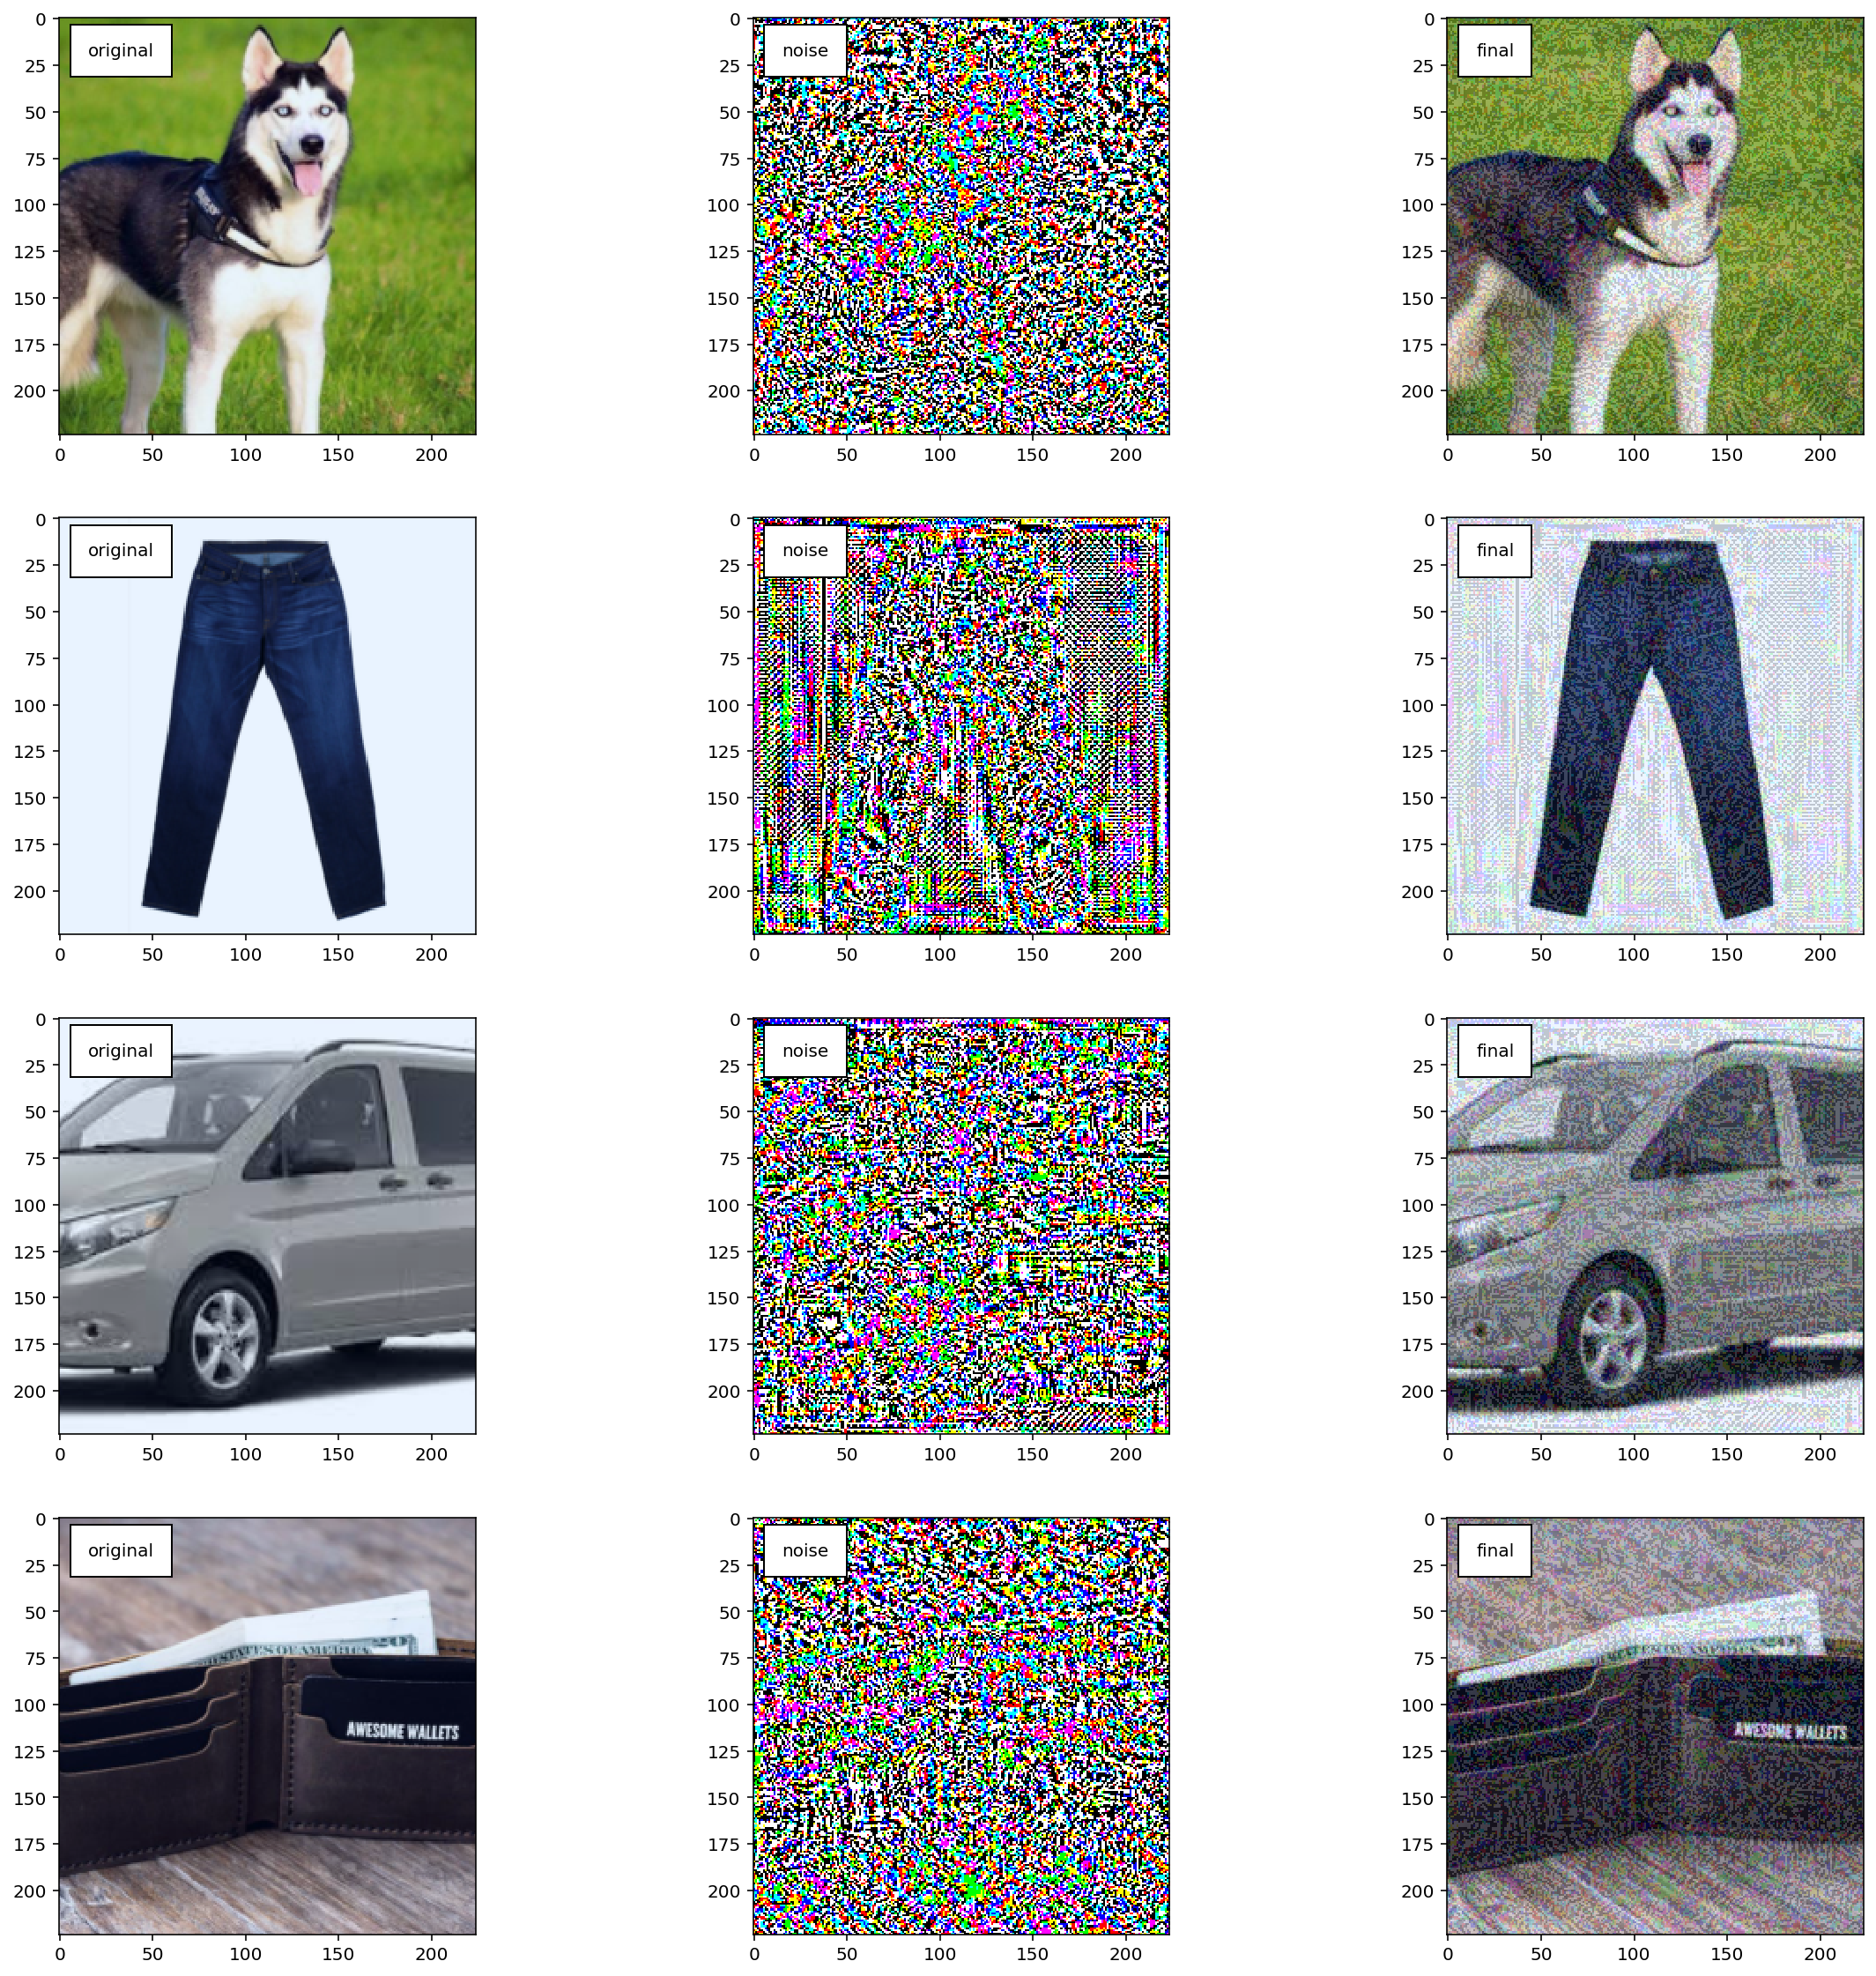

In [18]:
plt.figure(figsize=(20,20), dpi=144)
test(attack=True)
plt.show()